<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/Stock_Prices_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem   
Develop a **1D CNN model** to forecast **Tesla’s stock price** for the **next day** based on the **last 10 days** of historical data.  

---

## Solution Approach  

### Data Preprocessing  
- **Normalize** the closing prices between 0 and 1.  
- **Create a sliding window** of **10 days as input** and **next-day closing price as output**.  
- **Split data** into training (80%) and testing (20%).  

### Evaluation  
- **Compare predicted vs. actual stock prices** using **visualizations**.  
- **Convert predictions back to original scale** (inverse transform).  
- **Measure performance** using Mean Absolute Error (MAE).  

## Considerations  
**Market Volatility**: Unexpected events (news, earnings reports) impact stock prices.  
**Data Limitations**: External factors like interest rates and investor sentiment are not included.  
**Feature Expansion**: Future improvements could include technical indicators (RSI, MACD) and trading volume.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Set the path to the file you'd like to load
homeFolder = '/content/drive/MyDrive/Colab Notebooks/Forecasting/'
testFile = homeFolder + 'TSLA Testing.csv'
trainingFile = homeFolder + 'TSLA training.csv'

train_df =pd.read_csv(testFile)
test_df =pd.read_csv(trainingFile)

train_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-06-22,234.503326,246.833328,233.826660,236.086670,236.086670,101107500
1,2022-06-23,237.906662,239.316666,228.636673,235.070007,235.070007,104202600
2,2022-06-24,237.470001,246.066666,236.086670,245.706665,245.706665,95770800
3,2022-06-27,249.366669,252.070007,242.566666,244.919998,244.919998,89178300
4,2022-06-28,244.483337,249.970001,232.343338,232.663330,232.663330,90391200


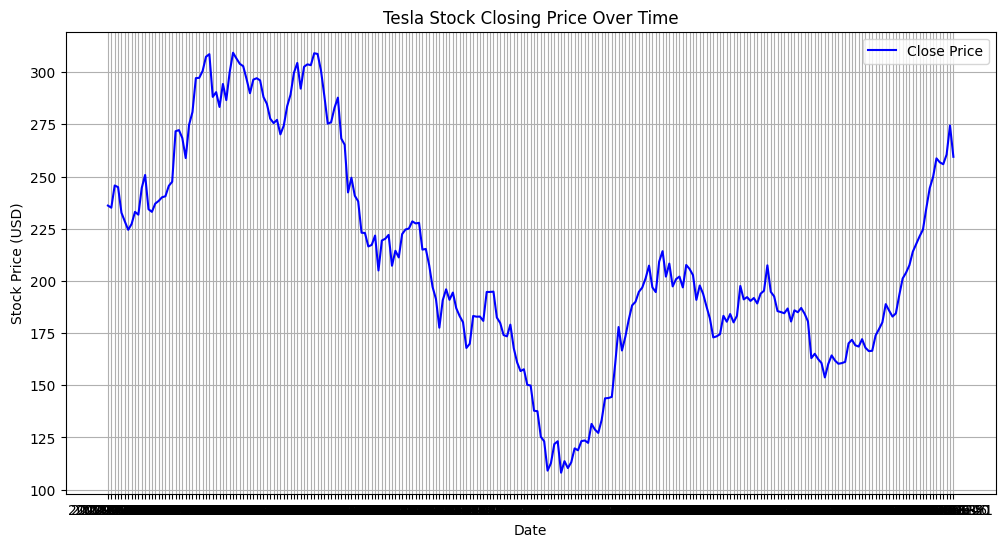

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Close'], label="Close Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()


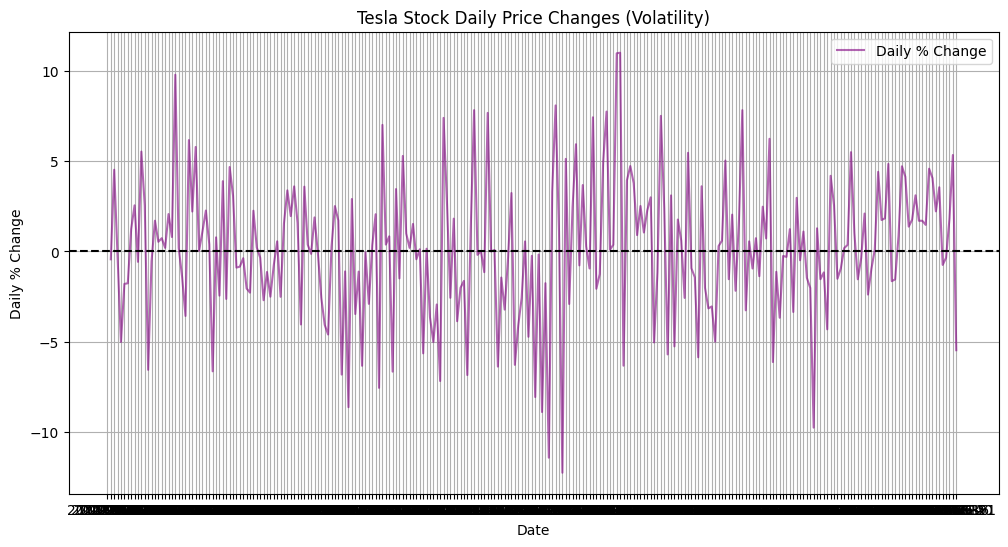

In [ ]:
train_df['Daily Change'] = train_df['Close'].pct_change() * 100  # Convert to percentage

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Daily Change'], label="Daily % Change", color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Daily % Change")
plt.title("Tesla Stock Daily Price Changes (Volatility)")
plt.legend()
plt.grid()
plt.show()


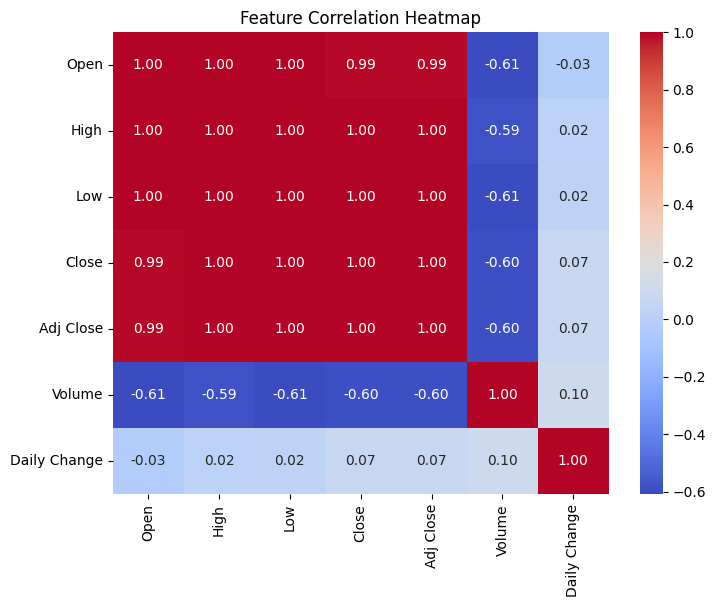

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df.drop(columns=['Date']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


##Predictive Model

### Model Architecture  
- **Input**: A **(10, 1)** time-series window of past stock prices.  
- **1D CNN Layers**:  
  - `Conv1D(filters=64, kernel_size=3, activation='relu')`  
  - `MaxPooling1D(pool_size=2)`  
  - `Flatten()`  
- **Fully Connected Layers**:  
  - `Dense(50, activation='relu')`  
  - `Dense(1, activation='linear')` (Predicts the next day’s price).  

### Training  
- **Loss function**: Mean Absolute Error (MAE).  
- **Optimizer**: Adam.  
- **Train for 50 epochs** with batch size 16.  

In [ ]:
#Date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Sort by Date
train_df = train_df.sort_values(by="Date")
test_df = test_df.sort_values(by="Date")

# Drop Date column (not needed for the model)
train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])

# Normalize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [ ]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Last 30 days as input
        y.append(data[i+seq_length, 3])  # Predict next day's closing price (Adj Close)
    return np.array(X), np.array(y)

SEQ_LENGTH = 30

X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

# Reshape for 1D CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, train_df.shape[1]))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, test_df.shape[1]))


In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, train_df.shape[1])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer (regression task)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 26, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,569 (37.38 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1975 - mae: 0.3720 - val_loss: 0.1643 - val_mae: 0.3289
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0337 - mae: 0.1574 - val_loss: 0.1458 - val_mae: 0.3115
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0259 - mae: 0.1308 - val_loss: 0.1363 - val_mae: 0.2988
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0255 - mae: 0.1380 - val_loss: 0.1370 - val_mae: 0.3020
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0259 - mae: 0.1300 - val_loss: 0.1501 - val_mae: 0.3114
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0252 - mae: 0.1329 - val_loss: 0.1592 - val_mae: 0.3209
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0211 - mae: 0.1163 - val_loss: 0.1550 - val_mae: 0.3161
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0254 - mae: 0.1325 - val_loss: 0.1350 - val_mae: 0.2979
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.020

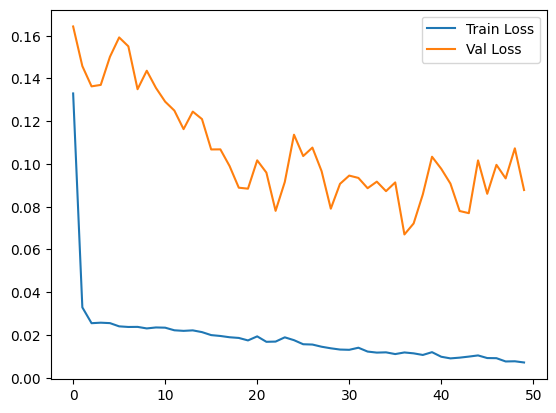

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


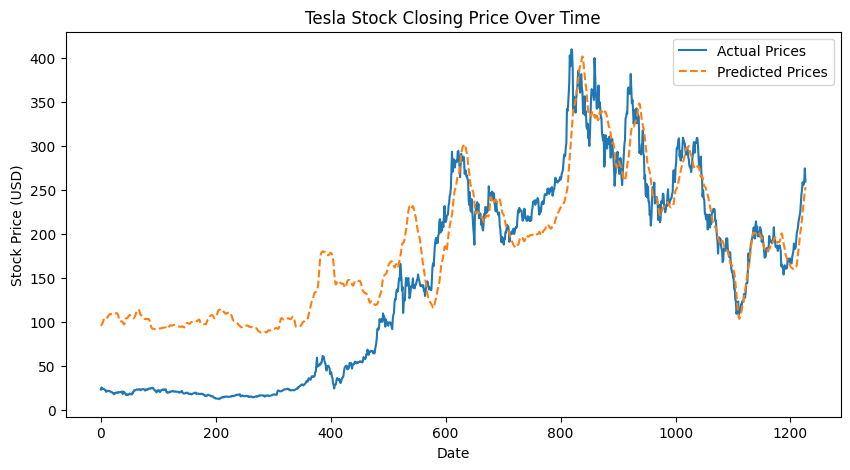

In [ ]:
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_actual = scaler.inverse_transform(test_scaled[SEQ_LENGTH:, :])[:, 3]  # Actual closing prices
predictions_actual = scaler.inverse_transform(np.hstack((test_scaled[SEQ_LENGTH:, :3],
                                                          predictions.reshape(-1,1),
                                                          test_scaled[SEQ_LENGTH:, 4:])))[:, 3]  # Predicted closing prices

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predictions_actual, label="Predicted Prices", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Closing Price Over Time")
plt.legend()
plt.show()


When is it a good moment to buy/sell??

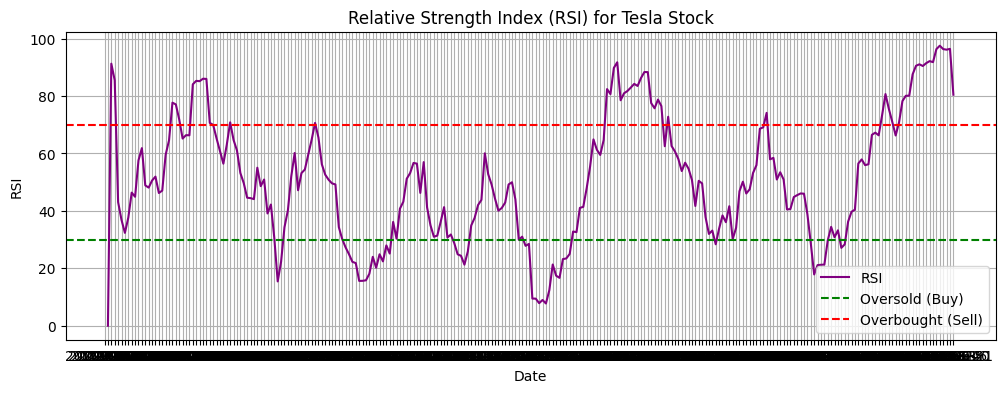

In [ ]:
import numpy as np

# Compute RSI
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

train_df['RSI'] = compute_RSI(train_df['Close'])

# Identify RSI buy/sell signals
train_df['RSI Buy'] = train_df['RSI'] < 30  # Oversold
train_df['RSI Sell'] = train_df['RSI'] > 70  # Overbought

# Plot RSI
plt.figure(figsize=(12, 4))
plt.plot(train_df['Date'], train_df['RSI'], label="RSI", color='purple')
plt.axhline(30, color='green', linestyle='dashed', label="Oversold (Buy)")
plt.axhline(70, color='red', linestyle='dashed', label="Overbought (Sell)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.title("Relative Strength Index (RSI) for Tesla Stock")
plt.legend()
plt.grid()
plt.show()


In [ ]:
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
# Load Tesla stock dataset
# Load Tesla stock dataset
train_data = pd.read_csv(trainingFile, parse_dates=["Date"], index_col="Date")
test_data = pd.read_csv(testFile, parse_dates=["Date"], index_col="Date")

# Compute RSI
window_size = 14
train_data['RSI'] = compute_rsi(train_data['Close'], window=window_size)
test_data['RSI'] = compute_rsi(test_data['Close'], window=window_size)
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Normalize RSI values
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['RSI_Scaled'] = scaler.fit_transform(train_data[['RSI']])
test_data['RSI_Scaled'] = scaler.transform(test_data[['RSI']])

In [ ]:
# Prepare dataset with sliding window
def create_sequences(data, lookback=10, target_day=3):
    X, y = [], []
    for i in range(len(data) - lookback - target_day):
        X.append(data[i: i + lookback])
        y.append(data[i + lookback + target_day])
    return np.array(X), np.array(y)

lookback = 10  # Past 10 days as input
X_train_3d, y_train_3d = create_sequences(train_data['RSI_Scaled'].values, lookback, target_day=3)
X_test_3d, y_test_3d = create_sequences(test_data['RSI_Scaled'].values, lookback, target_day=3)
X_train_7d, y_train_7d = create_sequences(train_data['RSI_Scaled'].values, lookback, target_day=7)
X_test_7d, y_test_7d = create_sequences(test_data['RSI_Scaled'].values, lookback, target_day=7)

# Reshape for 1D CNN
X_train_3d = X_train_3d.reshape((X_train_3d.shape[0], X_train_3d.shape[1], 1))
X_test_3d = X_test_3d.reshape((X_test_3d.shape[0], X_test_3d.shape[1], 1))
X_train_7d = X_train_7d.reshape((X_train_7d.shape[0], X_train_7d.shape[1], 1))
X_test_7d = X_test_7d.reshape((X_test_7d.shape[0], X_test_7d.shape[1], 1))


In [ ]:
# Build CNN model
def build_cnn():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(), loss='mae')
    return model

# Train models
model_3d = build_cnn()
model_7d = build_cnn()

model_3d.fit(X_train_3d, y_train_3d, epochs=50, batch_size=16, validation_data=(X_test_3d, y_test_3d), verbose=1)
model_7d.fit(X_train_7d, y_train_7d, epochs=50, batch_size=16, validation_data=(X_test_7d, y_test_7d), verbose=1)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2031 - val_loss: 0.1321
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1194 - val_loss: 0.1264
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1242 - val_loss: 0.1294
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1169 - val_loss: 0.1141
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1170 - val_loss: 0.1132
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1137 - val_loss: 0.1230
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1156 - val_loss: 0.1107
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1126 - val_loss: 0.1159
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1174 - val_loss: 0.1105
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1113 - val_loss: 0.1112
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1062 - val_loss: 0.1145
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1136 - val_lo

In [ ]:
# Predictions
y_pred_3d = model_3d.predict(X_test_3d)
y_pred_7d = model_7d.predict(X_test_7d)

# Inverse transform predictions
y_test_3d_actual = scaler.inverse_transform(y_test_3d.reshape(-1, 1))
y_pred_3d_actual = scaler.inverse_transform(y_pred_3d)
y_test_7d_actual = scaler.inverse_transform(y_test_7d.reshape(-1, 1))
y_pred_7d_actual = scaler.inverse_transform(y_pred_7d)

# Evaluate models
mae_3d = np.mean(np.abs(y_test_3d_actual - y_pred_3d_actual))
mae_7d = np.mean(np.abs(y_test_7d_actual - y_pred_7d_actual))
print(f"MAE for 3-day ahead prediction: {mae_3d:.4f}")
print(f"MAE for 7-day ahead prediction: {mae_7d:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE for 3-day ahead prediction: 9.3117
MAE for 7-day ahead prediction: 13.0078


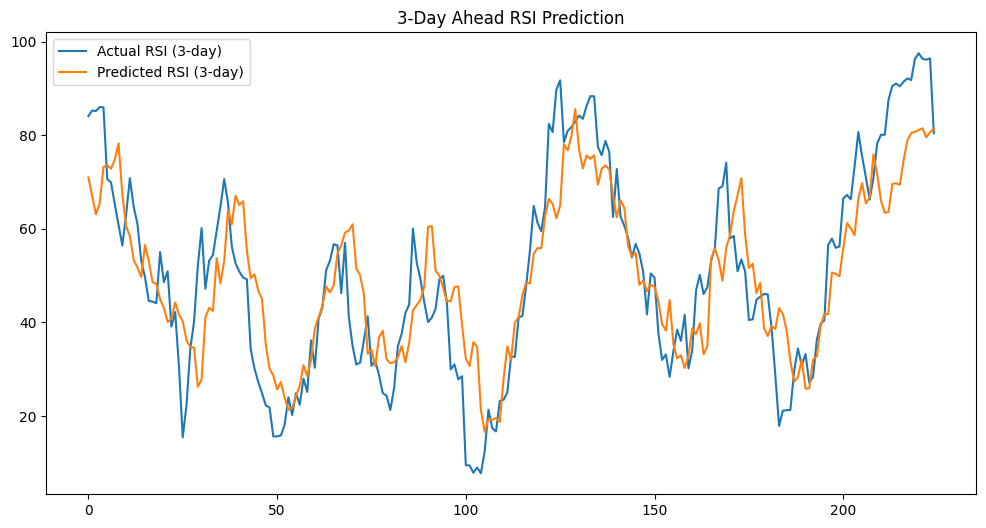

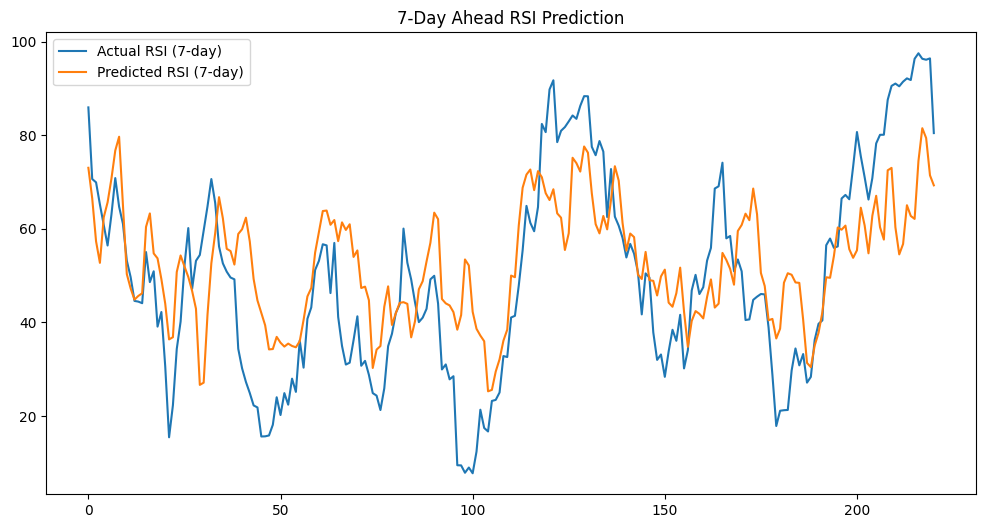

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_3d_actual, label='Actual RSI (3-day)')
plt.plot(y_pred_3d_actual, label='Predicted RSI (3-day)')
plt.legend()
plt.title("3-Day Ahead RSI Prediction")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_7d_actual, label='Actual RSI (7-day)')
plt.plot(y_pred_7d_actual, label='Predicted RSI (7-day)')
plt.legend()
plt.title("7-Day Ahead RSI Prediction")
plt.show()

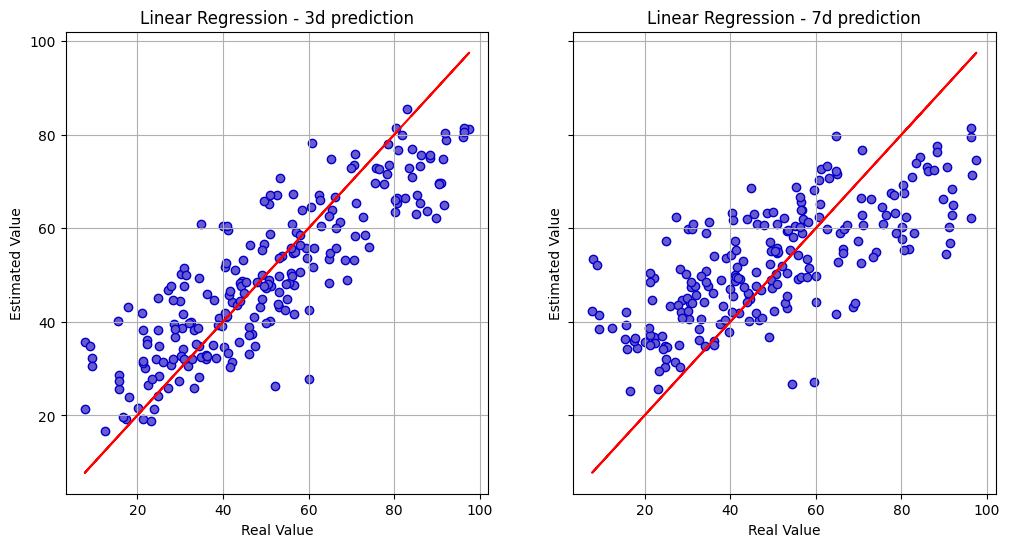

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey = True)

ax[0].scatter(y_test_3d_actual,y_pred_3d_actual,color="slateblue",edgecolor="mediumblue")
ax[0].plot(y_test_3d_actual, y_test_3d_actual, 'r')
ax[0].set_xlabel('Real Value')
ax[0].set_ylabel('Estimated Value')
ax[0].set_title('Linear Regression - 3d prediction')
ax[0].grid(True)

ax[1].scatter(y_test_7d_actual,y_pred_7d_actual,color="slateblue",edgecolor="mediumblue")
ax[1].plot(y_test_7d_actual,y_test_7d_actual,color="red")
ax[1].set_xlabel('Real Value')
ax[1].set_ylabel('Estimated Value')
ax[1].set_title('Linear Regression - 7d prediction')
ax[1].grid(True)

Too early predictions are not very trustworthy